I have worked independently.

In [1]:
import time
import numpy
import datetime
import re
import praw
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import *
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform


Reddit API credentials:
```python
reddit = praw.Reddit(

    client_id="xyz",
    client_secret="xyz",
    user_agent="NLP Test Sentiment analysis on posts about South Korea u/xyz"
)
```

Target all subreddits:
```python
subreddit = reddit.subreddit("all")
print(reddit.read_only)
```

Fetch 1000 posts with 'South Korea' in a title:

```python
def get_date(submission):
    time = submission.created
    return datetime.date.fromtimestamp(time)
```


Fetch recent posts:
```python
posts = []

for post in subreddit.search("South Korea South Korean", limit=1000):
    if post.is_self: 
        posts.append({
            "title": post.title,
            "selftext": post.selftext,
            "score": post.score,
            "comments": post.num_comments,
            "url": post.url,
            "time": get_date(post)
        
    })
```

Save to a DataFrame:
```python
df = pd.DataFrame(posts)
pd.set_option('display.max_colwidth', None) 

df.to_csv("reddit_posts.csv", index=False)
```

In [2]:
# The data can be uploaded to the script from reddit_posts.csv
df = pd.read_csv('reddit_posts.csv')

# Range of dates
min_date = df['time'].min()
max_date = df['time'].max()
print(f'The articles are from {min_date} to {max_date}')

The articles are from 2014-07-13 to 2024-12-06


In [3]:
### Find most frequent words in a big set of article titles

# Remove numbers and punctuation
df['tidy_title'] = df['title'].str.replace('[^a-zA-Z#]', ' ', regex=True)
df['tidy_title'] = df['tidy_title'].str.lower()
df['tidy_title'] = df['tidy_title'].str.replace('  ', ' ', regex=True)

# Keep 'Noth Korea' as an expression 
df['tidy_title'] = df['tidy_title'].apply(
    lambda x: re.sub(r'\bnorth korean\b', 'north_korea', 
                     re.sub(r'\bnorth korea\b', 'north_korea', 
                            re.sub(r'\bsouth korean\b', 'south_korea', 
                                   re.sub(r'\bsouth korea\b', 'south_korea', x))))
)




# Remove 'South Korea', 'korea' and 'korean' form the titles
df['tidy_title'] = df['tidy_title'].str.replace('south_korea', ' ')
df['tidy_title'] = df['tidy_title'].apply(
    lambda x: re.sub(r'\bkorean\b', ' ', x))
df['tidy_title'] = df['tidy_title'].apply(
    lambda x: re.sub(r'\bkorea\b', ' ', x))

In [4]:
# Perform tokenisation

tokenized_title = df['tidy_title'].copy().apply(lambda x: x.split())
stemmer = PorterStemmer()
stemmed_title= tokenized_title.apply(lambda x:[stemmer.stem(i) for i in x])
# Join tokens back into strings
processed_titles = stemmed_title.apply(lambda x: ' '.join(x))

# Extract Features
bow_vectorizer = CountVectorizer(max_features = 10,stop_words = 'english')
bow = bow_vectorizer.fit_transform(processed_titles)

In [5]:
# Convert the sparse matrix into 1D array and order in descending order
bow_array = bow.toarray()
word_array = bow_array.sum(axis=0) 
top_indices = word_array.flatten().argsort()[-10:][::-1] 

# Get corresponding words from the vectorizer
top_words = [bow_vectorizer.get_feature_names_out()[col] for col in top_indices]

# Total frequency of each word across all documents.
top_indices_2d = numpy.unravel_index(top_indices, word_array.shape)
top_frequencies = word_array[top_indices_2d]

# Display top 10 most common words
print('The most common words in the doncument are:')
for word, f in zip(top_words, top_frequencies):
    print(f"- {word}, Frequency: {f}")
    

The most common words in the doncument are:
- north_korea, Frequency: 9
- martial, Frequency: 7
- law, Frequency: 7
- group, Frequency: 5
- war, Frequency: 4
- vs, Frequency: 4
- match, Frequency: 4
- kim, Frequency: 4
- declar, Frequency: 4
- autist, Frequency: 4


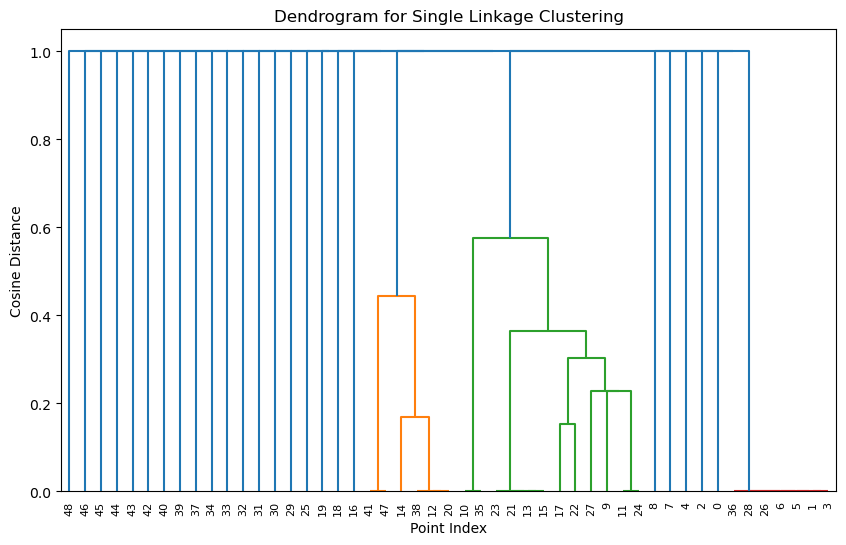

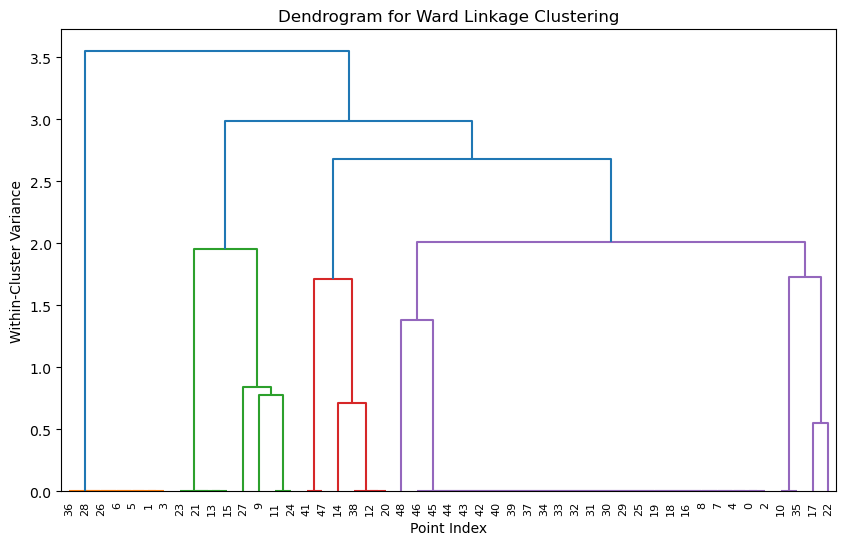

In [6]:
# Tokenization
titles_for_clustering = df['tidy_title'].copy()
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
bow_tfidf = vectorizer.fit_transform(titles_for_clustering).toarray()

# Single linkage hierarchical clustering
# Calcualate cosine distance
distance_matrix = cosine_distances(bow_tfidf)
Z_1 = linkage(squareform(distance_matrix), method='single')
# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z_1)
plt.title("Dendrogram for Single Linkage Clustering")
plt.xlabel("Point Index")
plt.ylabel("Cosine Distance")
plt.show()

# Ward linkage hierarchical clustering
distance_matrix_euclidean = euclidean_distances(bow_tfidf)
Z_2 = linkage(bow_tfidf, method='ward') 

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z_2)
plt.title("Dendrogram for Ward Linkage Clustering")
plt.xlabel("Point Index")
plt.ylabel("Within-Cluster Variance")
plt.show()


In [7]:
# Single linkage clustering results- poor performance
labels_1 = fcluster(Z_1, t=0.9, criterion='distance')  # Extract cluster labels from the linkage matrix
silhouette_avg_1 = silhouette_score(distance_matrix, labels_1, metric='precomputed')
print(f"Silhouette Score: {silhouette_avg_1}")
print(numpy.unique(labels_1))

Silhouette Score: 0.31015000184926816
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


In [8]:
# Ward linkage clustering results
labels_2 = fcluster(Z_2, t=1.5, criterion='distance')  # Extract cluster labels from the linkage matrix
silhouette_avg_2 = silhouette_score(distance_matrix_euclidean, labels_2, metric='precomputed')
print(f"Silhouette Score: {silhouette_avg_2}")
print(numpy.unique(labels_2))

Silhouette Score: 0.8633393272138178
[1 2 3 4 5 6 7 8]


In [9]:
# Print sample documents from selected clusters obtained in Ward linkage clustering

df_labels = pd.DataFrame({'title': df['title'], 'label': labels_2})

# Filter titles with label 1
label_1_titles = df_labels[df_labels['label'] == 1]['title']
print("Titles with label 1:")
print(label_1_titles.to_list())

# Filter titles with label 2
label_2_titles = df_labels[df_labels['label'] == 2]['title']
print("Titles with label 2:")
print(label_2_titles.to_list())

# Filter titles with label 8
label_8_titles = df_labels[df_labels['label'] == 8]['title']
print("Titles with label 8:")
print(label_8_titles.to_list())


Titles with label 1:
['SOUTH KOREAN MARTIAL LAW MEGATHREAD!', 'South Korean stocks down 6% today on South Korea declaring martial law, buy the dip', 'MT: South Korea Martial Law ', 'Emergency Martial Law declared in South Korea', 'South Korean Parliament overturns Martial Law decree', 'South Korea invokes Martial Law - MDs on strike specifically told to return to work or suffer sonsequences', 'We can get prepared Trump will try to follow this:  "South Korea\'s president declares martial law"']
Titles with label 2:
['North Korean Defector Who is Sending Information to North Korea', ' Japan publicly claims at UN, "There\'s no basis for comfort women claims"... South Korean representative remains silent, while the North Korean representative engages in heated debate', 'Why don’t North Korean border guards just immediately cross the border into South Korea?', 'My grandfather was born in North Korea but escaped to the South, ask him anything!']
Titles with label 8:
["What's going on with So

# Sentiment of coments from a chosen topic

Fetch comments from URLs:
```python
martial_subset = df[df['tidy_title'].str.contains('martial')]
url_set = martial_subset['url']
for url_i in url_set:
    post = reddit.submission(url = url_i)
    
    comments = []
    post.comments.replace_more(limit=0)  # retrieve comments, leaving nested comments out
    for comment in post.comments.list():
        comments.append({
            "comment": comment.body,
            "timestamp": comment.created_utc
        })
```
Save to a DataFrame and csv:
```python
df_comments = pd.DataFrame(comments)
df_comments.to_csv("reddit_martial_law_comments.csv", index=False)
```

In [ ]:
# The comments can be uploaded as a dataframe
df_comments = pd.read_csv('reddit_martial_law_comments.csv')
# Number of analysed comments
len(df_comments)

140

In [11]:
# Comment pre-processing
df_comments['comment_tidy'] = df_comments['comment'].apply(lambda x: re.sub('[^a-zA-Z#]', ' ', x))
df_comments['comment_tidy'] = df_comments['comment_tidy'].str.lower()


In [12]:
# Textblob polarity
df_comments['sentiment_textblob'] = [TextBlob(comment).sentiment.polarity for comment in df_comments['comment_tidy']]
# Sentiment analysis results using Textblob
print(f"Positive sentiment using TextBlob: {len(df_comments[df_comments['sentiment_textblob'] > 0])}")
print(f"Negative sentiment using TextBlob: {len(df_comments[df_comments['sentiment_textblob'] < 0])}")


Positive sentiment using TextBlob: 66
Negative sentiment using TextBlob: 34


In [13]:
# Download pre-defined dictionary classifying negative and positive words
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
df_comments['sentiment_vader'] = [sid.polarity_scores(comment)['compound'] for comment in df_comments['comment']]
# Sentiment analysis results using Vader
print(f"Positive sentiment using Vader: {len(df_comments[df_comments['sentiment_vader'] > 0])}")
print(f"Negative sentiment using Vader: {len(df_comments[df_comments['sentiment_vader'] < 0])}")

Positive sentiment using Vader: 48
Negative sentiment using Vader: 59


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/urszulaludwiczak/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
# Convert timestamps to a date format
df_comments['date'] = [time.strftime("%d %b %Y %H:%M:%S", time.gmtime(i)) for i in df_comments['timestamp']]
df_comments = df_comments.sort_values(by = ['date'])
print(f"Time range of the analysed comments: {df_comments['date'].min()} - {df_comments['date'].max()}")


Time range of the analysed comments: 03 Dec 2024 17:05:15 - 06 Dec 2024 03:10:01


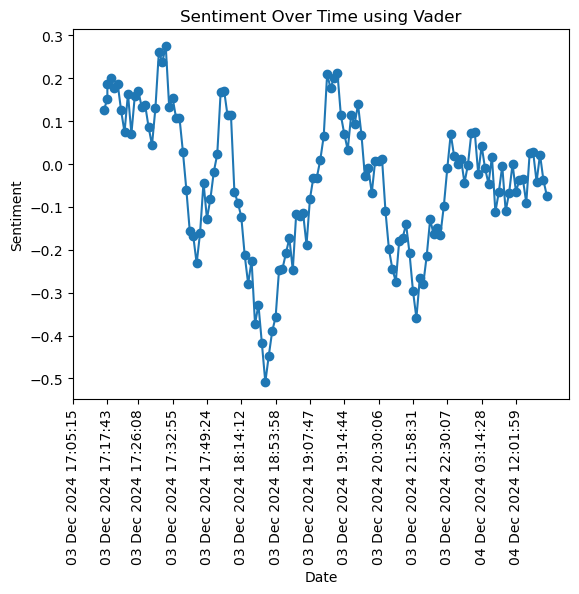

In [15]:
# Sentiment of comments over time
df_comments['sentiment_smooth'] = df_comments['sentiment_vader'].rolling(window=10).mean()
# Moving average smoothing
plt.plot(df_comments['date'], df_comments['sentiment_smooth'], marker='o')
plt.title('Sentiment Over Time using Vader')
plt.xlabel('Date')
plt.ylabel('Sentiment')
ticks = df_comments['date'][::10]
plt.xticks(ticks, rotation=90)
plt.show()
